# Lidar Particle Filter

The purpose of this project is to look at modeling a lidar.  We will make an example map with however many known points we please, and we will simulate what a lidar would see if looking in the room.  We will be able to simulate the beam parameters, noise parameters, etc., and then use a partical filter to localize a robot in the room.  The goal is to better understand the interaction between the parameters and learn to select the right lidar setup for a real world task before coding it.

First, let's load the libs we need.

In [1]:
import math
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

Next we will draw some features of a map.  These are essentially a sparse collection of points representing, say, walls in a room and other static obstacles in the room.  Basically we just want to make a collection of points that define a map of our known universe.  Since one simple thing to mimic is a room with straight walls and periodic known points on the boundary, let's use some helpers to generate these and then extend it to work with rectangles in general. This way we can fairly easily generate a collection of points that is representative of, say, a room with some simple objects like furniture in it.  While in the real world the map may have ambiguity (noise) associated with the known points, for the moment we will work on localizing with perfectly known points.  The location of our robot is depicted in green.

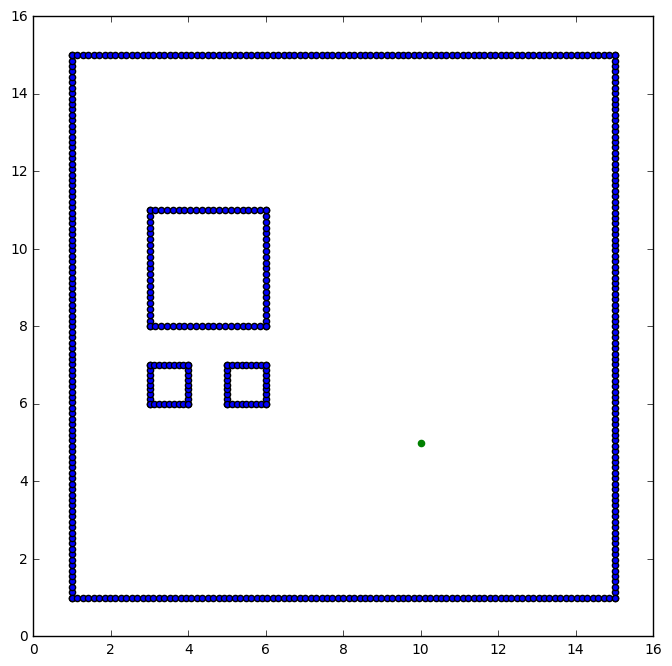

In [2]:
class Room(object):

    def map_range_x(self, start, stop, number, y):
        return [[start + (stop - start) * i / number, y] for i in range(number + 1)]

    def map_range_y(self, start, stop, number, x):
        return [[x, start + (stop - start) * i / number] for i in range(number + 1)]

    def map_square(self, top_left, bottom_right, points):
        tl_x, tl_y = top_left
        br_x, br_y = bottom_right
        res  = self.map_range_y(tl_y, br_y, points, tl_x)
        res += self.map_range_y(tl_y, br_y, points, br_x)
        res += self.map_range_x(tl_x, br_x, points, tl_y)
        res += self.map_range_x(tl_x, br_x, points, br_y)
        return res

    def make_room(self):
        walls = self.map_square((1.0,1.0), (15.0,15.0), 100)
        table = self.map_square((3.0,8.0), (6.0,11.0), 20)
        chair1 = self.map_square((3.0,6.0), (4.0,7.0), 8)
        chair2 = self.map_square((5.0,6.0), (6.0,7.0), 8)
        return walls + table + chair1 + chair2


# Set the plot size        
plt.figure(figsize=(8,8))    
    
# Build the room map points
r = Room()
room = r.make_room()

# Unzip the x-y coordinates
x, y = zip(*room)

# Plot the points
plt.scatter(x, y)  

# Plot where our robot is 
plt.scatter(10.0, 5.0, color='green')

plt.show()

Next we will position a candidate observer in room and simulate a directional sweep of the room in the way that would generate something similar to what a lidar would produce.  This will result in data that is tuples of angle and distance.  The way this is done is to first compute the distance and angle from the robot location to each point room point.  For each discrete angle in our simulated lidar sweep, we will find the points that are within that sweep and record the closest one.  It is not a particularly performant way of accomplishing the task, but it is adequate for working on the process.  We will also plot the distance points so that we can visualize what the lidar would appear as and confirm that it is sensible given the parameters we have set.

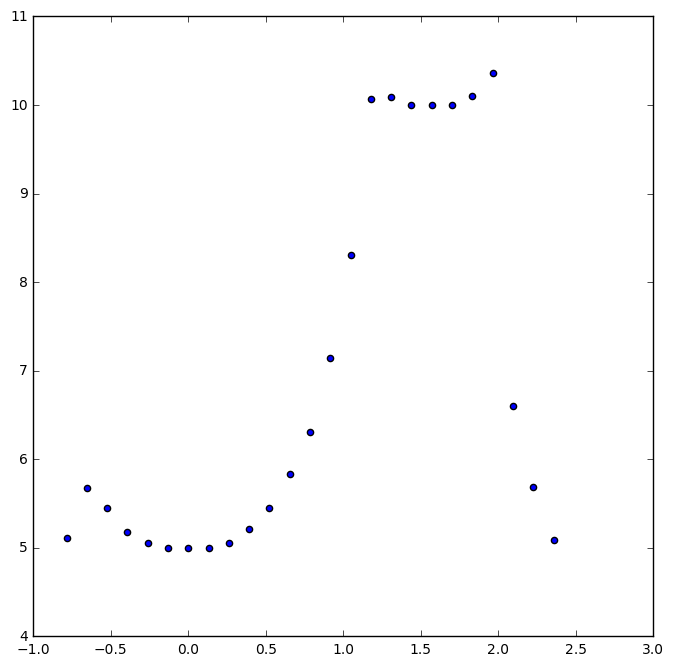

In [3]:
class RoomView(object):

    def __init__(self, points, angle_sweep, sweep_number):
        self.points = points
        self.angle_sweep = angle_sweep
        self.sweep_number = sweep_number
        
    def angle_range(self, center):
        delta = self.angle_sweep
        n = self.sweep_number
        return [(center - delta) + 2 * delta * i / n for i in range(2 * n + 1)]

    def angle_and_distance(self, robot_location, point_location):
        (rx, ry) = robot_location
        (px, py) = point_location
        dx = px - rx
        dy = py - ry
        distance = math.sqrt(dx**2 + dy**2)
        angle = math.atan2(dy, dx)
        return (angle, distance)

    def closest_point_in_swath(self, min_angle, max_angle, robot_location):
        pts = []
        for p in self.points:
            angle, distance = self.angle_and_distance(robot_location, p)
            if angle > min_angle and angle < max_angle:
                pts.append(distance)
        pts = sorted(pts)
        if len(pts) > 0:
            return pts[0]
        return None

    def lidar_points(self, robot_location, robot_angle):
        pts = []
        angles = self.angle_range(robot_angle)
        delta = 2 * self.angle_sweep / self.sweep_number
        for a in angles:
            min_a = a - delta
            max_a = a + delta
            distance = self.closest_point_in_swath(min_a, max_a, robot_location)
            if distance is not None:
                pts.append((a, distance))
        return pts
        

# Set the plot size        
plt.figure(figsize=(8,8))

# Set up a room view with a pi/4 half-angle aperture and 15 angle slices on each side
rv = RoomView(room, math.pi/4, 12)

# Get the lidar points for a particle facing due East
points = rv.lidar_points((10.0,5.0), 0.0)

# Unzip the angle-distance tuple
a, d = zip(*points)

# Plot as a scatter plot
plt.scatter(a, d)
plt.show()

Real lidar has a noisy signal.  This is because all measurements have noise.  In our example here, the angle actually has noise because we are reporting a measurement that is not exactly at the angle we were looking.  However, this is not the same type of error that a real lidar has.  Real lidar with have sampled the environment similarly, detecting perhaps the most prominent reflection within the code of the detector.  However, it will also have ambiguity with regard to the reported angle, whereas we have a computed angle with high accuracy.  Moreover, it will have error with regard to the distance, whereas again we have a high accuracy computation.  That said, we will model the error by simply adding error to each measure drawn from an approprate normally distributed noise source.

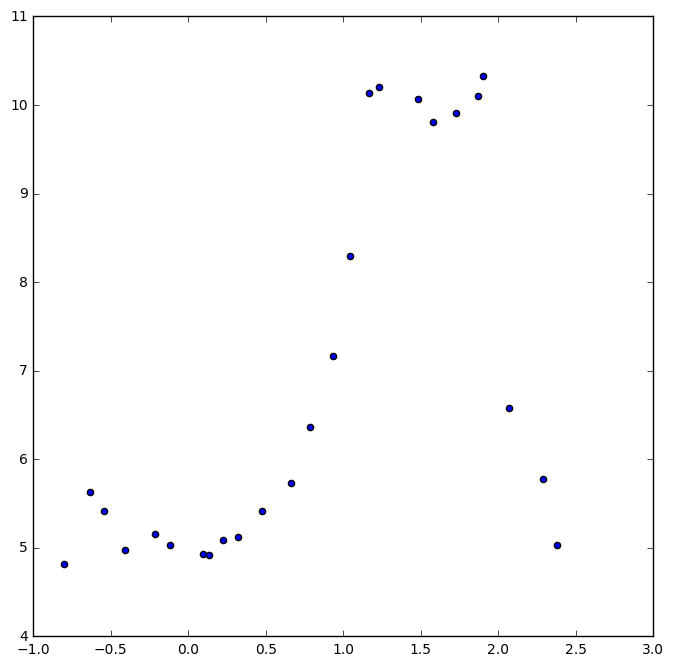

In [4]:
class LidarNoise(object):
    
    def __init__(self, angle_std, distance_std):
        self.angle_std = angle_std
        self.distance_std = distance_std

    def add_error(self, view_points):
        res = []
        for p in view_points:
            angle, distance = p
            new_angle = angle + np.random.normal(0.0, self.angle_std)
            new_distance = distance + np.random.normal(0.0, self.distance_std)
            res.append((new_angle, new_distance))
        return res
    

# Set the plot size        
plt.figure(figsize=(8,8))

# Generate noisy points
ln = LidarNoise(0.05, 0.1)
noisy_points = ln.add_error(points)

# Unzip the angle-distance tuple
a, d = zip(*noisy_points)

# Plot as a scatter plot
plt.scatter(a, d)
plt.show()


Now we can generate a bunch of points in the room that will be used for the particle filter.  These are just random points observing the room in random directions.  The point is, we do not know where the robot is, but if we continually refine information gleened from a bunch of particles that *could* be the robot, we will start knowing where the robot is because the observation from the robot's perspective will coincide with particles that are closest to the robot's location (and oriented in the same direction).

First thing we need to do is generate some particles.  We could apply some constraints so that we know that the particles are onle inside the room and not under the table or chairs (supposing the robot cannot go to these places), but this isn't strictly necassary since the particles in these locations will quickly find themselves excluded anyway.  Since the room itself occupies coordinates between the corners `(1.0, 1.0)` and `(15.0, 15.0)`, we will simply fill the space with points in this area without regard for the furniture.  No reason to extend it past the wall confines.

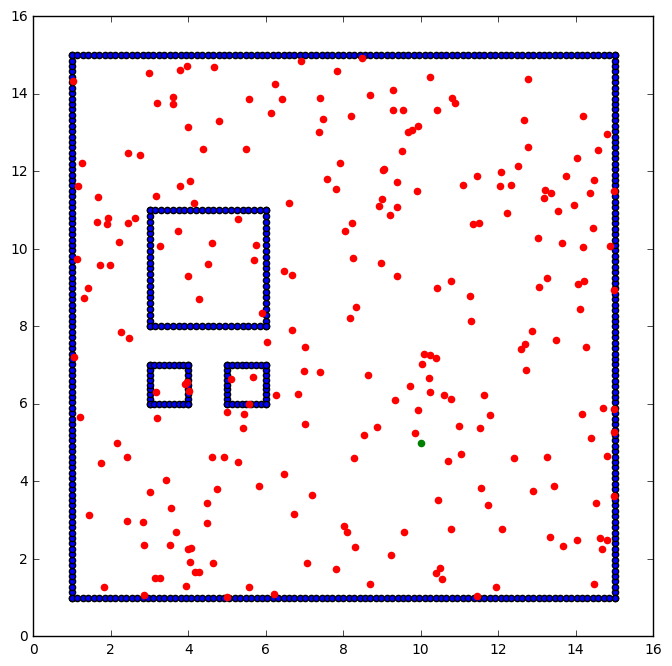

In [5]:
class Particles(object):
    
    def __init__(self, num_particles, bounds):
        self.num_particles = num_particles
        top_left, bottom_right = bounds
        self.x_min, self.y_min = top_left
        self.x_max, self.y_max = bottom_right
        
    def generate(self):
        res = []
        for i in range(self.num_particles):
            x = np.random.uniform(self.x_min, self.x_max)
            y = np.random.uniform(self.y_min, self.y_max)
            res.append((x,y))
        return res
    
    
# Set the plot size        
plt.figure(figsize=(8,8))    
    
# Unzip the x-y coordinates of the room
x, y = zip(*room)

# Plot the points for the room
plt.scatter(x, y) 

# Generate particles
p = Particles(250, ((1.,1.), (15.,15.)))
ps = p.generate()
             
# Unzip the point for the particles
x, y = zip(*ps)
                    
# Plot a different color
plt.scatter(x, y, color='red') 

# Plot where our robot is 
plt.scatter(10.0, 5.0, color='green')

# Plot
plt.show()

Now what we need to do is update our `Particles` class so that it has a great deal more functionality.  Rather than just returning a bunch of points bounded by our room, we need to add a direction the point is oriented toward and add enough machinery to our class so that we can evaluate the robot's observed lidar in the context of the particle, compute a weight for each particle, and then be able to filter the particles so that we refine the estimate of position based on the particles by amplifying the better candidates and attenuating the rest.  Moreover, we need a `Particle` class that represents the behaviors of each particle within the context of the group of `Particles`.  We also need to formalize a `Robot` class a bit so that we can use it for dependencies having to do with robot activities. The `Robot` class includes facilities for being able to change the location and direction in the relative sense, and the `Particles` class follows suite on a collection of particles.

In [20]:
class Robot(object):
    
    def __init__(self, location, direction):
        self.location = location
        self.direction = direction
        
    def translate(self, translation):
        px, py = self.location
        tx, ty = translation
        self.location = (px+tx, py+ty)
        
    def rotate(self, angle):
        self.direction += angle
        

class Particle(object):
    
    COVAR_RADIUS = 2.0
    COVAR_ANGLE = 2.0
    
    def __init__(self, location, direction):
        self.location = location
        self.direction = direction
        
    def translate(self, translation):
        px, py = self.location
        tx, ty = translation
        self.location = (px+tx, py+ty)
        
    def rotate(self, angle):
        self.direction += angle
        
    def dist(self, p1, p2):
        return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
    
    def robot_cartesian_coordinates(self, lidar_scan, robot):
        points = []
        rx, ry = robot.location
        for p in lidar_scan:
            angle, distance = p
            x = rx + distance * math.cos(angle)
            y = ry + distance * math.sin(angle)
            points.append((x,y))
        return points
    
    def transform_coordinates(self, lidar_scan, room, robot):
        points = []
        robot_cartesian_points = self.robot_cartesian_coordinates(lidar_scan, robot)
        pnt_x, pnt_y = self.location
        angle = self.direction 
        for p in robot_cartesian_points:
            obs_x, obs_y = p
            x = pnt_x + obs_x * math.cos(angle) + obs_y * math.sin(angle)    # + -
            y = pnt_y - obs_x * math.sin(angle) + obs_y * math.cos(angle)    # + +
            points.append((x,y))
        return points
        
    def associate_points(self, points, room):
        associations = []
        for i, p in enumerate(points):
            smallest_distance = 1.0e99
            for j, r in enumerate(room):
                index = 0
                d = self.dist(p, r)
                if d < smallest_distance:
                    smallest_distance = d
                    index = j
            associations.append((points[i], room[j]))
        return associations
    
    def compute_aggregate_weight(self, associations):
        weight = 1.0
        mean = [0.0, 0.0]
        cov = [[self.COVAR_RADIUS, 0.0],[0.0, self.COVAR_ANGLE]]  
        mvn = multivariate_normal(mean=mean, cov=cov)
        for a in associations:
            point, room = a
            px, py = point
            rx, ry = room
            sx, sy = self.location
            dp_x, dp_y = px - sx, py - sy
            dr_x, dr_y = rx - sx, ry - sy
            radius_p = math.sqrt(dp_x**2 + dp_y**2)
            angle_p = math.atan2(dp_y, dp_x)
            radius_r = math.sqrt(dr_x**2 + dr_y**2)
            angle_r = math.atan2(dr_y, dr_x)
            dr = radius_p - radius_r
            da = angle_p - angle_r
            weight *= mvn.pdf([dr, da])
        return weight
        
    def lidar_scan(self, lidar_scan, room, robot):
        points = self.transform_coordinates(lidar_scan, room, robot)
        associations = self.associate_points(points, room)
        return self.compute_aggregate_weight(associations)
        
    
class Particles(object):
    
    LOCATION_STD = 0.1
    DIRECTION_STD = 0.1
    
    def __init__(self, num_particles, bounds, room, robot):
        self.num_particles = num_particles
        top_left, bottom_right = bounds
        self.x_min, self.y_min = top_left
        self.x_max, self.y_max = bottom_right
        self.room = room
        self.robot = robot
        self.intialize()
        
    def intialize(self):
        self.particles = []
        for i in range(self.num_particles):
            x = np.random.uniform(self.x_min, self.x_max)
            y = np.random.uniform(self.y_min, self.y_max)
            d = np.random.uniform(0.0, 2 * math.pi)
            particle = Particle((x,y), d)
            self.particles.append(particle)
            
    def translate(self, translation):
        for p in self.particles:
            p.translate(translation)
        
    def rotate(self, angle):
        for p in self.particles:
            p.rotate(angle)
     
    def generate_weights(self, room_view):
        weights = []
        total_weight = 0.0
        for p in self.particles:
            weight = p.lidar_scan(room_view, self.room, self.robot)
            weights.append(weight)
            total_weight += weight
        return [weight / total_weight for weight in weights]
        
    def resample_particles(self, weights):
        new_particles = []
        indices = [i for i, _ in enumerate(weights)]
        for i in indices:
            selected_index = np.random.choice(indices, p=weights)
            particle = self.particles[selected_index]
            new_particles.append(particle)
        self.particles = new_particles
            
    def update_weights(self, room_view):
        weights = self.generate_weights(room_view)
        print(weights)
        self.resample_particles(weights)
        
    def update_positions(self):
        for p in self.particles:
            x, y = p.location
            x += np.random.normal(0.0, self.LOCATION_STD)
            y += np.random.normal(0.0, self.LOCATION_STD)
            print(x, y)
            p.location = (x,y)
            p.direction += np.random.normal(0.0, self.DIRECTION_STD)
            
    def update(self, room_view):
        self.update_weights(room_view)
        self.update_positions()
        for p in self.particles:
            print(p.location)
        
    def get_particles(self):
        return [p.location for p in self.particles]
        
    def average_particle_position(self):
        ps = self.get_particles()
        x, y = zip(*ps)
        return (np.average(x), np.average(y))    
        

Now all we have to do is make an instance of `Robot` and an instance of `Particles`.  This depends on having the `room` defined, so of course we need to have that.  Now we have a quite easy interface for iterating the process and plotting the particles so that we can see them converge to the robot position.

In [ ]:
# Create a new robot
r = Robot((10.0,5.0),  # Location
          0.0)         # Direction

# Create a new Particles object
p = Particles(200,                  # Number of particles
              ((1.,1.),(15.,15.)),  # Room bounds
              room,                 # The room
              r)                    # Our robot

# Update the particles and print them a few times
for i in range(5):
    p.update(noisy_points)
    pos = p.average_particle_position()
    print('  ')

